In [ ]:
!nvidia-smi

Tue Mar  2 16:53:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import numpy as np
from tensorflow.keras import layers
from keras.preprocessing import image
import tensorflow as tf 
from keras.models import Model,load_model
from keras.utils import to_categorical
import os
import keras
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Lambda
from keras.optimizers import Adam
from keras import backend as K
import random
from PIL import Image 
from random import shuffle

**Prepare**

In [ ]:
import numpy as np
from numpy import genfromtxt
from numpy import asarray
import math
import copy
import os
from PIL import Image 
import cv2

patch_size = 64 #input = 64x64
label_size = 128 #output = 128x128

#get RGGB bayer image
def bayer_reverse(img):
    height,width,c = img.shape;
    tmp = np.zeros([height,width]);
    for i in range( height ):
        for j in range( width ):
            if i % 2 == 0 :
                if j % 2 == 0:
                    tmp[i][j] = img[i][j][0];#R
                else:
                    tmp[i][j] = img[i][j][1];#G
            else :
                if j % 2 == 0:
                    tmp[i][j] = img[i][j][1];#G
                else:
                    tmp[i][j] = img[i][j][2];#B

    return tmp;

#split image to prepare the train set
def split(img,name,dir_path):
    height,width,c = img.shape;
    # print(img.shape)
    count = 0;
    for i in range(0,height,30):
        for j in range(0,width,30):
            if( i + label_size < height and j + label_size < width ):
                tmp = np.zeros([label_size,label_size,3]);
                tmp2 = np.zeros([label_size,label_size,3]);
                
                tmp = img[ i : i + label_size, j : j + label_size,:];
                                
                path = os.path.join(dir_path,'label/'+name.split('.')[0] +'_'+str(count)+'.png')                
                im = Image.fromarray(tmp)               
                tmp2[:,:,0] = tmp[:,:,2]
                tmp2[:,:,1] = tmp[:,:,1]                
                tmp2[:,:,2] = tmp[:,:,0]                
                cv2.imwrite(path,tmp2)

                zoom = im.resize((patch_size,patch_size)) 
                zoom2 = np.zeros([patch_size,patch_size,3]);
                # gray =  np.zeros([patch_size,patch_size]);
                
                zoom = np.array(zoom)
                zoom2[:,:,0] = zoom[:,:,2]
                zoom2[:,:,1] = zoom[:,:,1]                
                zoom2[:,:,2] = zoom[:,:,0]
                
                # zoom2 = bayer_reverse(zoom2)
                #gray = gray/255                
                path = os.path.join(dir_path,'patch/'+name.split('.')[0] +'_'+str(count)+'.png')
                # im = Image.fromarray(zoom2)           
                cv2.imwrite(path, zoom2)

                count = count + 1

def main():
    path = 'drive/My Drive/Colab Notebooks/undergraduate_project'
    if not os.path.exists(os.path.join(path,'patch')):
        os.makedirs(os.path.join(path,'patch'))
    
    if not os.path.exists(os.path.join(path,'label')):
        os.makedirs(os.path.join(path,'label'))
    
    dataset_path = os.path.join(path,'origin')
    entries = os.listdir(dataset_path)
    for entry in entries:
        print(entry)
        img_path = dataset_path + '/' + entry
        img = Image.open(img_path)
        img = np.array(img)   
        split(img,entry,path)



if __name__ == '__main__':
    main()


42078.png
92059.png
97017.png
65019.png
56028.png
67079.png
46076.png
95006.png
55075.png
71046.png
45077.png
42044.png
55067.png
61086.png
66075.png
43083.png
61060.png
59078.png
90076.png
80099.png
78019.png
60079.png
66039.png
94079.png
65074.png
65132.png
43070.png
65010.png
68077.png
87065.png
48055.png
54005.png
76002.png
100075.png
105019.png
104022.png
103041.png
105053.png
100080.png
100098.png
106025.png
106020.png


In [ ]:
batch_size = 32
oti = 'adam'
lr = 0.001
e_num = 50
dir_path = 'drive/My Drive/Colab Notebooks/undergraduate_project'

**Training**

In [ ]:
import numpy as np
from tensorflow.keras import layers
from keras.preprocessing import image
import tensorflow as tf 
from keras.models import Model,load_model
from keras.utils import to_categorical
import os
import keras
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Lambda
from keras.optimizers import Adam
from keras import backend as K
import random
from PIL import Image 
from random import shuffle

# def main():

train_image = []
train_label = []

dir_path = 'drive/My Drive/Colab Notebooks/undergraduate_project'
patch_path = os.path.join(dir_path,'patch')
entries = os.listdir(patch_path)
for entry in entries:
  im = image.load_img(patch_path+'/'+entry, target_size = (64, 64))
  img = image.img_to_array(im)    
  # img = img[:,:,0]    
  # img = img[:,:,np.newaxis]           # Modify here!!!
  train_image.append(img)
train_image= np.stack(train_image)

print(train_image.shape)# (x,128,128,1)
  

label_path = os.path.join(dir_path,'label')
entries = os.listdir(label_path)
for entry in entries:
  im = image.load_img(label_path+'/'+entry, target_size = (128, 128))
  img = image.img_to_array(im)
  train_label.append(img)
train_label = np.stack(train_label)

print(train_label.shape)# (x,256,256,3)



index = [i for i in range(train_image.shape[0])]
shuffle(index)
train_image = train_image[index,:,:,:];
train_label = train_label[index,:,:,:];

# model.save(os.path.join(dir_path,'model.h5'))

# if __name__ == '__main__':
#   main()


(3528, 64, 64, 3)
(3528, 128, 128, 3)


In [ ]:
############################# Model Structure ################################################
def create_model():
  inputs = keras.Input(shape=(None,None,3))

  ##Subpixel Construction
  sub_layer_2 = Lambda(lambda x:tf.nn.space_to_depth(x,2)) 
  init = sub_layer_2(inputs=inputs)


  ##Learning Residual (DCNN)
  ####Conv 3x3x64x64 + PReLu
  x = keras.layers.Conv2D(filters=64,
                      kernel_size = 3, 
                      strides = 1,  # 2
                      padding = 'same', 
                      input_shape = (None,None,3))(init)

  x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)

  ####Residual Block
  for i in range(6):
    Conv1 = keras.layers.Conv2D(filters=64,
                        kernel_size = 3, 
                        strides = 1,  # 2
                        padding = 'same',
                        input_shape = (None,None,64))(x)
    
    PReLu = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(Conv1)
    Conv2 = keras.layers.Conv2D(filters=64,
                        kernel_size = 3, 
                        strides = 1,  # 2
                        padding = 'same',
                        input_shape = (None,None,64))(PReLu)
    
    
    x = keras.layers.Add()([Conv2,x])
    x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)

  ####Conv 3x3x64x64 + PReLu
  x = keras.layers.Conv2D(filters=64,
                      kernel_size = 3, 
                      strides = 1,  # 2
                      padding = 'same', 
                      input_shape = (None,None,1))(x)

  x = keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)

  ####Conv 3x3x64x48
  x = keras.layers.Conv2D(filters=48,
                      kernel_size = 3, 
                      strides = 1,  
                      padding = 'same',                      
                      input_shape = (None,None,64))(x)

  ###########Learning Residual (DCNN)############

  ##Recovery From Subpixel
  sub_layer = Lambda(lambda x:tf.nn.depth_to_space(x,4)) 
  Residual_Output = sub_layer(inputs=x)


  ##Initial Prediction
  R = Lambda(lambda x: x[:,:,:,0])(init)
  G = Lambda(lambda x: x[:,:,:,1:3])(init)
  G = Lambda(lambda x: K.mean(x, axis=3))(G)
  B = Lambda(lambda x: x[:,:,:,3])(init)
  # print(init.shape)
  # print(R.shape)
  # print(G.shape)
  # print(B.shape)
  R = Lambda(lambda x: tf.expand_dims(x, -1))(R)
  G = Lambda(lambda x: tf.expand_dims(x, -1))(G)
  B = Lambda(lambda x: tf.expand_dims(x, -1))(B)

  #rgb = tf.keras.backend.stack((R, G,B),axis =  3)
  # print(R.shape)
  rg = keras.layers.Concatenate(axis = 3)([R , G])
  rgb = keras.layers.Concatenate(axis = 3)([rg,B])
  # print(rgb.shape)
  Coarse_Output = keras.layers.UpSampling2D(size=(4, 4))(rgb)

  ## + 
  outputs = keras.layers.Add()([Residual_Output,Coarse_Output])

  model = keras.Model(inputs=inputs, outputs=outputs, name="JDMSR_model")  
  return model

In [ ]:
model = create_model()
model.summary()
model.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss = 'mean_squared_error', metrics = ['accuracy'])

#histories = Histories()
checkpoint = ModelCheckpoint(os.path.join(dir_path,'model.hdf5'),verbose=1, monitor='val_loss', 
                              save_best_only=False,save_weights_only=True)
rrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_lr=0.0000002)

history = model.fit(train_image, train_label, epochs=e_num, batch_size=batch_size,verbose=1,validation_split = 0.2,callbacks=[checkpoint,rrp],shuffle = True)

Model: "JDMSR_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_90 (Lambda)              (None, None, None, 1 0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, None, None, 6 6976        lambda_90[0][0]                  
__________________________________________________________________________________________________
p_re_lu_140 (PReLU)             (None, None, None, 6 64          conv2d_150[0][0]                 
________________________________________________________________________________________

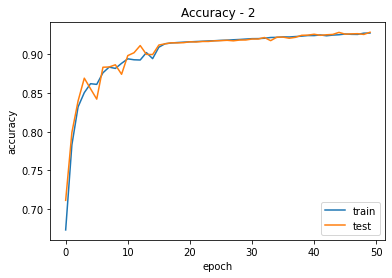

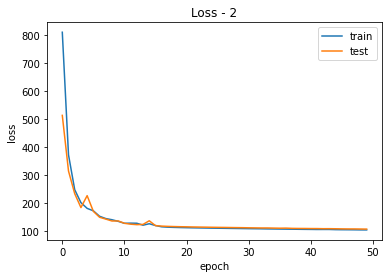

In [ ]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy - 2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('model_accuracy2.png')
plt.show()

plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss - 2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('model_loss2.png')
plt.show()

**Validation**

In [ ]:
from keras.models import load_model
from keras.layers import Lambda
from keras.preprocessing import image
import keras
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from keras import backend as K
import os
import math
import shutil

width_change = 0
height_change = 0
oti = 'adam'


dir_path = 'drive/My Drive/Colab Notebooks/undergraduate_project'
model = create_model()
model.load_weights(os.path.join(dir_path,'model.hdf5'))

input_path = os.path.join(dir_path, 'koda')
output_path = os.path.join(dir_path, 'output')
output_path2 = os.path.join(dir_path, 'output2')

if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs(output_path)

if os.path.exists(output_path2):
    shutil.rmtree(output_path2)
os.makedirs(output_path2)

entries = os.listdir(input_path)

for entry in entries:
    # Test Image
    path = input_path+'/'+entry
    test_image = Image.open(path)
    path = output_path+'/'+entry
    test_image.save(path)
    
    test_image = test_image.resize((test_image.size[0]//2, test_image.size[1]//2), Image.BILINEAR)
    print(test_image.size)
    test_image = np.array(test_image)
    print(test_image.shape)
    test_image = test_image[np.newaxis,:,:]
    print(test_image.shape)

    out = model.predict(test_image)
    out = out[0]   
    out = image.array_to_img(out)
    path = output_path2+'/'+entry
    out.save(path)

(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(256, 384)
(384, 256, 3)
(1, 384, 256, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(256, 384)
(384, 256, 3)
(1, 384, 256, 3)
(256, 384)
(384, 256, 3)
(1, 384, 256, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(256, 384)
(384, 256, 3)
(1, 384, 256, 3)
(256, 384)
(384, 256, 3)
(1, 384, 256, 3)
(256, 384)
(384, 256, 3)
(1, 384, 256, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 384, 3)
(384, 256)
(256, 384, 3)
(1, 256, 

**Performance**

In [ ]:
import cv2
import numpy as np
import math
import os
from google.colab.patches import cv2_imshow
from skimage.measure import compare_ssim

def calculate_psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    max_value = 255.0
    return 20 * math.log10(max_value / math.sqrt(mse))
    

path = 'drive/My Drive/Colab Notebooks/undergraduate_project' 
input_path = os.path.join(path,'output')
output_path = os.path.join(path,'output2')
entries = os.listdir(input_path)
count = 0
total_psnr = 0.
total_ssim = 0.

for entry in entries:
  img1 = cv2.imread(os.path.join(input_path,entry))
  img2 = cv2.imread(os.path.join(output_path,entry))
  # print(img1.shape)
  # print(img2.shape)
  # img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]), interpolation=cv2.INTER_CUBIC)
  psnr = calculate_psnr(img1,img2)
  print("PSNR-{0}: {1:.10f}dB".format(entry,psnr))
  ssim = compare_ssim(img1, img2, multichannel=True)
  print("SSIM-{0}: {1:.10f}".format(entry,ssim))
  total_psnr += psnr
  total_ssim += ssim
  count += 1
print(count)
# cv2_imshow(img1)
# cv2_imshow(img2)

total_psnr = total_psnr / count
total_ssim = total_ssim / count
print("\n=====================================")
print("Average PSNR:{:.10f}".format(total_psnr))
print("Average SSIM:{:.10f}".format(total_ssim))




PSNR-kodim01.png: 29.6688313698dB
SSIM-kodim01.png: 0.7402381485
PSNR-kodim02.png: 30.8001837367dB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


SSIM-kodim02.png: 0.8285498725
PSNR-kodim03.png: 29.4456865926dB
SSIM-kodim03.png: 0.8682236163
PSNR-kodim04.png: 32.7806014078dB
SSIM-kodim04.png: 0.8761432259
PSNR-kodim05.png: 29.3972739309dB
SSIM-kodim05.png: 0.7978959537
PSNR-kodim07.png: 32.5771530659dB
SSIM-kodim07.png: 0.9219070559
PSNR-kodim06.png: 29.4735399786dB
SSIM-kodim06.png: 0.7893169815
PSNR-kodim08.png: 28.7507987796dB
SSIM-kodim08.png: 0.7590662005
PSNR-kodim09.png: 31.0849536670dB
SSIM-kodim09.png: 0.8865617307
PSNR-kodim10.png: 27.7217898324dB
SSIM-kodim10.png: 0.8743538142
PSNR-kodim11.png: 30.0973129045dB
SSIM-kodim11.png: 0.7991506365
PSNR-kodim12.png: 27.8171053245dB
SSIM-kodim12.png: 0.8703030300
PSNR-kodim14.png: 28.7035281208dB
SSIM-kodim14.png: 0.7790208949
PSNR-kodim13.png: 28.7066187538dB
SSIM-kodim13.png: 0.6860446377
PSNR-kodim15.png: 29.8578886554dB
SSIM-kodim15.png: 0.8608264588
PSNR-kodim16.png: 30.8476164798dB
SSIM-kodim16.png: 0.8430196666
PSNR-kodim17.png: 29.6406710625dB
SSIM-kodim17.png: 0.86204